In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

from tensorflow.keras import layers

E0000 00:00:1753183691.131741      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230
Matplotlib is building the font cache; this may take a moment.


In [43]:
# Config 
INPUT_DIR = Path("/kaggle/working/output_wav2vec_custom_augmented")
OUTPUT_DIR = Path("./output_confmr_lr2_class_tpu")
OUTPUT_DIR.mkdir(exist_ok=True)

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 16
EPOCHS = 400
LEARNING_RATE = 1e-5
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
OUTPUT_DIR = Path("./")
BEST_MODEL_PATH = OUTPUT_DIR / "best_confmr_lr2_model.keras"

In [ ]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

--- Initializing TPU Strategy ---
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753183729.178482      10 service.cc:148] XLA service 0x5c5026197d40 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753183729.178528      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753183729.178533      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753183729.178536      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753183729.178538      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753183729.178541      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753183729.178544      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753183729.178546      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753183729.178549      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
print("\nLoading all compressed features")

train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']


print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


Loading all compressed features
All compressed data loaded successfully.
X_train shape: (33043, 150, 768)
y_train shape: (33043, 6)


In [7]:
# Remove the last column ('NoStutter') from the labels
y_train = y_train[:, :-1]
y_val = y_val[:, :-1]
y_test = y_test[:, :-1]

# Filter out samples that now have NO labels
train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and modified successfully.")
print(f"New X_train shape: {X_train.shape}")

Data loaded and modified successfully.
New X_train shape: (28881, 150, 768)


In [8]:
print("\n Verifying final training set distribution after augmentation")

final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))


 Verifying final training set distribution after augmentation
Final distribution of labels in the training set (including augmented samples):
Block           10848
Interjection    10824
Prolongation    10800
SoundRep        10203
WordRep         10040
dtype: int64


In [9]:
print("\nBuilding tf.data pipeline")

def prepare_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True)
val_dataset = prepare_dataset(X_val, y_val)
test_dataset = prepare_dataset(X_test, y_test)
print("Datasets created successfully.")


Building tf.data pipeline
Datasets created successfully.


In [ ]:
with strategy.scope():
    print("\nBuilding Conformer Model")

    # Conformer Block
    def conformer_block(x, num_heads=4, ff_dim=128, dropout=0.1):
        # Convolution Module
        x_conv = layers.LayerNormalization()(x)
        x_conv = layers.Conv1D(filters=EMBEDDING_DIM * 2, kernel_size=1, activation="relu")(x_conv)
        x_conv = layers.DepthwiseConv1D(kernel_size=3, padding="same")(x_conv)
        x_conv = layers.BatchNormalization()(x_conv)
        x_conv = layers.Activation("swish")(x_conv)
        x_conv = layers.Conv1D(filters=EMBEDDING_DIM, kernel_size=1)(x_conv)
        x_conv = layers.Dropout(dropout)(x_conv)
        x = x + x_conv # Residual connection

        # Attention Module
        x_attn = layers.LayerNormalization()(x)
        x_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=EMBEDDING_DIM // num_heads)(x_attn, x_attn)
        x_attn = layers.Dropout(dropout)(x_attn)
        x = x + x_attn # Residual connection

        # Feed Forward Module
        x_ff = layers.LayerNormalization()(x)
        x_ff = layers.Dense(ff_dim, activation="swish")(x_ff)
        x_ff = layers.Dropout(dropout)(x_ff)
        x_ff = layers.Dense(EMBEDDING_DIM)(x_ff)
        x = x + x_ff # Residual connection

        return x

    def build_conformer_classifier(input_shape, num_classes):
        inputs = layers.Input(shape=input_shape)
        x = inputs

        # Applies Conformer blocks
        x = conformer_block(x, num_heads=4, ff_dim=256)
        x = conformer_block(x, num_heads=4, ff_dim=256)

        # Pools the sequence to a single vector
        x = layers.GlobalAveragePooling1D()(x)

        # Classifier head
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='sigmoid')(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc', multi_label=True)]
        )
        return model

    model = build_conformer_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)

print(f"LEARNING RATE: {LEARNING_RATE}")
print(f"BATCH SIZE: {BATCH_SIZE}")


Building Conformer Model


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 150, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ input_layer_5[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 150, 1536) │  1,181,184 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv1d    │ (None, 150, 1536) │      6,144 │ conv1d_4[0][0]    │
│ (DepthwiseConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 1536) │      6,144 │ depthwise_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 150, 1536) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 150, 768)  │  1,180,416 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 150, 768)  │          0 │ conv1d_5[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 150, 768)  │          0 │ input_layer_5[0]… │
│                     │                   │            │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 768)  │  2,362,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 150, 768)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 150, 768)  │          0 │ add_12[0][0],     │
│                     │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 150, 256)  │    196,864 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 150, 256)  │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 150, 768)  │    197,376 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 150, 768)  │          0 │ add_13[0][0],     │
│                     │                   │            │ dense_23[0][0]  

 Total params: 10,369,285 (39.56 MB)

 Trainable params: 10,363,141 (39.53 MB)

 Non-trainable params: 6,144 (24.00 KB)

LEARNING RATE: 1e-05
BATCH SIZE: 128


In [45]:
print("\nStarting Training on TPU")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


Starting Training on TPU
Epoch 1/400


I0000 00:00:1753208568.523441      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:17246797013149694942
I0000 00:00:1753208570.313571     782 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13913399006996530930), session_name()
I0000 00:00:1753208588.365225     782 tpu_compile_op_common.cc:245] Compilation of 13913399006996530930 with session name  took 18.051471483s and succeeded
I0000 00:00:1753208588.418533     782 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13913399006996530930), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_17246797013149694942", property.function_library_fingerprint = 16209821150881738858, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wra

225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2361 - auc: 0.5895 - loss: 0.6539 - precision: 0.4883 - recall: 0.3035

I0000 00:00:1753208599.463336     800 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5796542504556209139), session_name()
I0000 00:00:1753208617.214988     800 tpu_compile_op_common.cc:245] Compilation of 5796542504556209139 with session name  took 17.751566584s and succeeded
I0000 00:00:1753208617.266404     800 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5796542504556209139), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_17246797013149694942", property.function_library_fingerprint = 16209821150881738858, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "11,150,768,;11,5,;", property.guaranteed_constants_size = 0, embedding_

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.2362 - auc: 0.5897 - loss: 0.6538 - precision: 0.4885 - recall: 0.3034

I0000 00:00:1753208634.852258      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:10739120294791410644
I0000 00:00:1753208635.366485     791 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(422295266813059047), session_name()
I0000 00:00:1753208637.237284     791 tpu_compile_op_common.cc:245] Compilation of 422295266813059047 with session name  took 1.870680719s and succeeded
I0000 00:00:1753208637.246658     791 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(422295266813059047), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_10739120294791410644", property.function_library_fingerprint = 16188781050993549006, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z =


Epoch 1: val_auc improved from -inf to 0.66634, saving model to best_confmr_lr2_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 89s 227ms/step - accuracy: 0.2363 - auc: 0.5898 - loss: 0.6537 - precision: 0.4887 - recall: 0.3033 - val_accuracy: 0.2066 - val_auc: 0.6663 - val_loss: 0.6519 - val_precision: 0.5147 - val_recall: 0.1836
Epoch 2/400
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2870 - auc: 0.6558 - loss: 0.6195 - precision: 0.5684 - recall: 0.3193
Epoch 2: val_auc improved from 0.66634 to 0.69321, saving model to best_confmr_lr2_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 42s 128ms/step - accuracy: 0.2872 - auc: 0.6559 - loss: 0.6194 - precision: 0.5686 - recall: 0.3195 - val_accuracy: 0.2114 - val_auc: 0.6932 - val_loss: 0.6505 - val_precision: 0.5043 - val_recall: 0.3317
Epoch 3/400
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3291 - auc: 0.6815 - loss: 0.6059 - precision: 0.5953 - recall: 0.3718
Epoch 3: val_auc improved from 0.69321 to 0.71105, saving model to


--- Evaluating Model on the Test Set ---


I0000 00:00:1753209558.047915      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:16486520658014281352
E0000 00:00:1753209558.123601      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_5_1/batch_normalization_4_1/Cast/ReadVariableOp.
I0000 00:00:1753209558.287637     773 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(15060962088579803443), session_name()
I0000 00:00:1753209559.720417     773 tpu_compile_op_common.cc:245] Compilation of 15060962088579803443 with session name  took 1.432700536s and succeeded
I0000 00:00:1753209559.726181     773 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(15060962088579803443), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_16486520658014281352", property.function_library_fingerprint = 11273012821402104703, property.mlir

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

I0000 00:00:1753209565.726923      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:13579757836096463724
I0000 00:00:1753209565.985334     797 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2090804317232352023), session_name()
I0000 00:00:1753209568.097986     797 tpu_compile_op_common.cc:245] Compilation of 2090804317232352023 with session name  took 2.112577512s and succeeded
I0000 00:00:1753209568.104338     797 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(2090804317232352023), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13579757836096463724", property.function_library_fingerprint = 9046158929247127201, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topol

55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 222ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.64      0.52      0.57      2613
       Block       0.62      0.48      0.54      3501
    SoundRep       0.60      0.48      0.53      1891
     WordRep       0.53      0.41      0.47      1742
Interjection       0.77      0.75      0.76      3344

   micro avg       0.66      0.55      0.60     13091
   macro avg       0.63      0.53      0.57     13091
weighted avg       0.65      0.55      0.59     13091
 samples avg       0.63      0.56      0.56     13091


--- Generating plots for model training history... ---


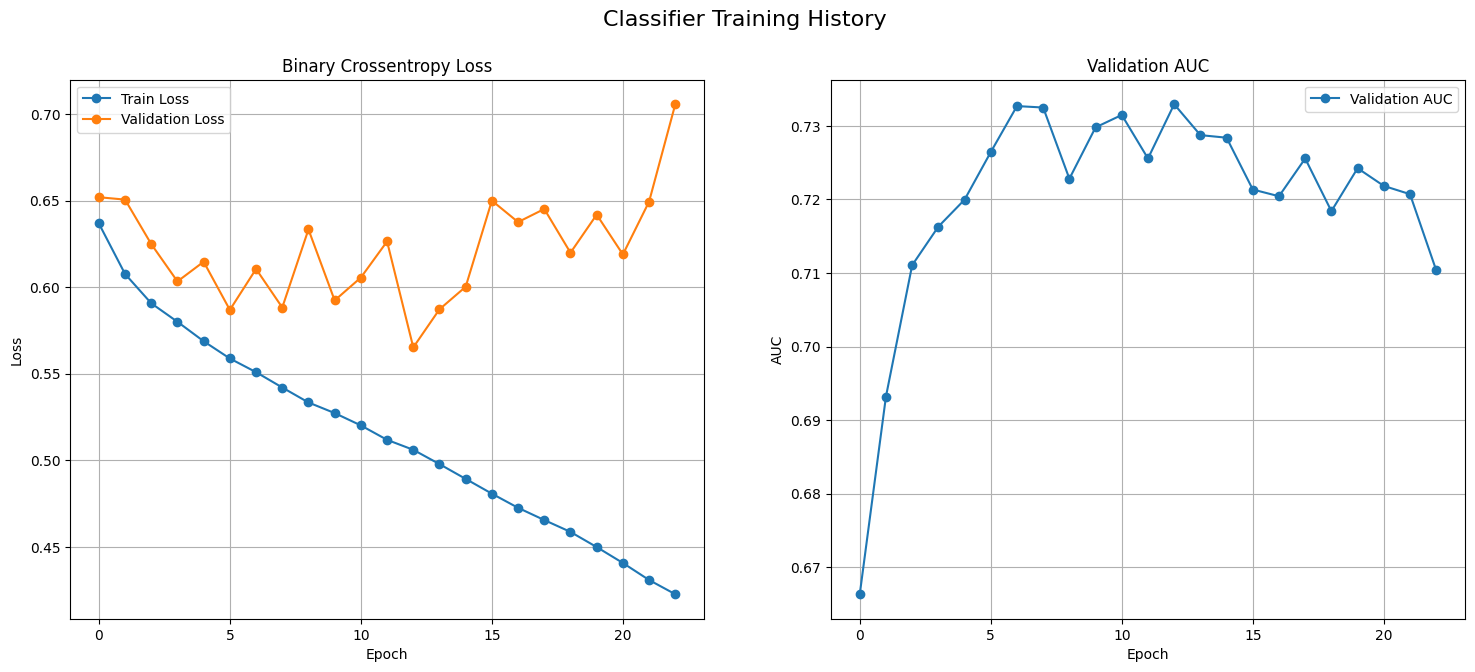

In [ ]:

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()

